In [1]:
import cv2
import random
import numpy as np
import time
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from singleton_decorator import singleton

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

from ultralytics import YOLO
from torch import no_grad as Torch_No_Grad

In [7]:
@singleton
class Detection:
    def __init__(self, weight_adres=None):
        self._model = self.Load_Model(weight_adres)
        self.Warm_Up()
        
    def Warm_Up(self):
        print("Warming Up Model!")
        with Torch_No_Grad(): self._model.predict(np.zeros((640,640,3)))
        print("Model Warmed Up!")
    
    @staticmethod
    def Load_Model(weight_adres):
        if weight_adres is None: model = YOLO('yolov8x.pt')
        else: 
            try: model = YOLO(f'{weight_adres}.pt')
            except FileNotFoundError as error: 
                print(f'{error} - loading default version')
                model = YOLO('yolov8x.pt')
            
        print("Model Loaded Successfuly!!")
        return model
    
    def Object_Detection(self, img):
        def Crop_Image(image, x, y, w, h, extension_percentage=0.15):
            height_extension = int(h * extension_percentage)
            width_extension = int(w * extension_percentage * 0.009)  # Smaller extension for width

            new_x = max(0, x - width_extension)
            new_y = max(0, y - height_extension)
            new_w = min(image.shape[1], w + 2 * width_extension)
            new_h = min(image.shape[0], h + height_extension)

            extended_image = image[new_y:new_h, new_x:new_w]
            return image[new_y:new_h, new_x:new_w], [new_x,new_y,new_w,new_h] 
        
        
        cordinations = []
        
        with Torch_No_Grad(): results = self._model.predict(img)
        
        if len(results[0]) == 0: pass
        else:
            if type(img) == list: img_len = len(img)
            else: img_len = 1
            
            for i in range(img_len):
                temp = []
                
                for result in results[i]:
                    for box in result.boxes:
                        predict = result.names[box.cls.item()]
                        probe = box.conf.item() * 100
                        bounding_boxes = box.xyxy.tolist()[0]

                        print(f'{predict} - {probe}')

                        if probe > 30:
                            x = int(round(bounding_boxes[0]))
                            y = int(round(bounding_boxes[1]))
                            w = int(round(bounding_boxes[2]))
                            h = int(round(bounding_boxes[3]))

                            temp.append((Crop_Image(img,x,y,w,h)))

                cordinations.append(temp)

        return cordinations

In [5]:
@singleton
class Execution:
    def __init__(self):
        self._colors = []
    
    @staticmethod
    def Pre_Proc_Image(frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(np.array(frame), (1250,750))
        return frame

    def Scetch_On_Frame(self,frame,coordinates):
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2]
        h = coordinates[3]
        
        while True:
            color = (random.randint(1, 255), random.randint(1, 255), random.randint(1, 255))
            if color in self._colors: continue
            else: 
                self._colors.append(color)
                break
        frame = cv2.rectangle(np.array(frame), (x,y,abs(w-(x)),abs(h-(y))), color, 10)
        
        return frame

In [9]:
detection = Detection('x')
execution = Execution()

opencv_image = cv2.imread("2.jpg")  

rgb_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)

frame = cv2.resize(np.array(rgb_image), (1250,750))

# # pil_image = Image.fromarray(rgb_image)

coordinations = detection.Object_Detection(frame)
print("======")

# if len(coordinations[0]) == 0: pass
# else:

#     tables = list(map(lambda t: (t[0]), coordinations[0]))

#     persons_coordinations = detection.Object_Detection(tables,label='person')


#     for indx,person_info in enumerate(persons_coordinations):
#         if not person_info: continue

#         x = coordinations[0][indx][1][0]
#         y = coordinations[0][indx][1][1]
#         w = coordinations[0][indx][1][2]
#         h = coordinations[0][indx][1][3]

#         import random

#         random_tuple = (random.randint(1, 255), random.randint(1, 255), random.randint(1, 255))

#         frame = cv2.rectangle(np.array(frame), (x,y,abs(w-(x)),abs(h-(y))), random_tuple, 10)



0: 384x640 2 persons, 3 chairs, 3 tvs, 1 keyboard, 260.8ms
Speed: 15.0ms preprocess, 260.8ms inference, 17.8ms postprocess per image at shape (1, 3, 384, 640)


chair - 94.32147741317749
chair - 92.849862575531
tv - 92.575603723526
keyboard - 91.80131554603577
person - 88.50889205932617
tv - 87.48031258583069
chair - 85.18211841583252
person - 84.04505252838135
tv - 43.85461509227753


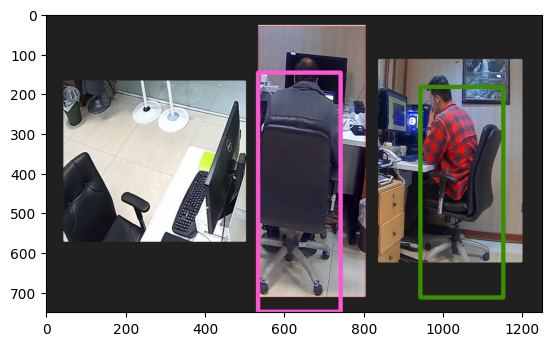

In [9]:
%matplotlib inline

# display(plt.imshow(tables[2]))

display(plt.imshow(frame))